# Notebook 3: Text-to-Image DCGAN for 64x64 HumanFaces

This tutorial combines two approaches - the text-to-image synthesis [Generative Adversarial Text to Image Synthesis](https://arxiv.org/pdf/1605.05396.pdf) (see Notebook 1) and the [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (see Notebook 2).

As mentioned in the previous notebooks, we have a huge gap between the images we need and the actual available training data. And this even gets worse if we would like to add additional facial characteristics to control the image creation of the generator. So, this tutorial will focus on the technical implementation and rather disregard the results.

## Setup
Import required dependencies/packages and define input/output locations.

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.9.1'

Check whether your GPU is correctly set up.
I'm using a NVIDIA RTX 2080 with CUDA 11.2 and cuDNN 8.4.1.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import time
from tqdm import tqdm
from PIL import Image

In [5]:
data_dir = "data/humanfaces"
dataset_dir = f"{data_dir}/dataset"
output_dir = "output/3-text-to-image-dcgan-humanfaces-64x64"
checkpoint_dir = f"{output_dir}/training_checkpoints"

## The dataset

The dataset is published under the [CC0 1.0 Public Domain Dedication](https://creativecommons.org/publicdomain/zero/1.0/) license on [Kaggle](https://www.kaggle.com/datasets/ashwingupta3012/human-faces).


In [6]:
if not os.path.exists(dataset_dir) or len(os.listdir(dataset_dir)) == 0:
    print("Please download the dataset manually and place the images in ./data/humanfaces/dataset")
    print("https://www.kaggle.com/datasets/ashwingupta3012/human-faces")
    raise FileNotFoundError("Data not found.")

As the publisher stated the dataset is "a thorough mix of all common creeds, races, age groups and profiles in an attempt to create an unbiased dataset". Not only the people on the images are different, even the shapes vary. The goal of this notebook is to create a random human face. In order to decrease the complexity of the task, we manually labeled some images of men of all creeds, races and age groups that are not cut off and facing towards the camera.

These are the facial characteristics that we've labeled:
- **hair_length** *(short, medium, very short, long, nan, bald, semi bald)*
- **hair_style** *(light, thick, fine, curly, frizzy, nan, straight, dishevelled)*
- **eyes** *(small, normal, round, almond-shaped, narrow, nan, differently-sized, wide)*
- **eyebrow** *(bushy, thick, fine, well-defined, nan)*
- **glasses** *(yes, no, nan)*
- **face** *(rectangular, oval, distinctive, round, slim, nan, wide)*
- **skin** *(many wrinkles, normal, some wrinkles, freckles)*
- **forehead** *(high, normal, wide, short, nan)*
- **nose** *(normal, wide, large, nan, wonky, small)*
- **beard** *(no, three-day, full, nan, special)*
- **mouth** *(thin, normal, full, nan)*
- **ears** *(large, normal, small, nan, protruding)*

Load and prepare the dataset

In [7]:
df = pd.read_csv(f"{data_dir}/humanfaces_labels.csv", sep=";")
print(f"Total Amount: {len(df)}")
df.iloc[[0]]

Total Amount: 401


,file,hair_length,hair_style,eyes,eyebrow,glasses,face,skin,forehead,nose,beard,mouth,ears
0,1 (1).jpeg,short,light,small,bushy,yes,rectangular,many wrinkles,high,normal,no,thin,large


Delete rows in which the hair length or style is not labeled.

In [8]:
df["hair_length"].replace('', np.nan, inplace=True)
df["hair_style"].replace('', np.nan, inplace=True)
df.dropna(subset=["hair_length"], inplace=True)
df.dropna(subset=["hair_style"], inplace=True)
print(f"Amount: {len(df)}")

Amount: 349


Replace rows with empty strings - for all other values except for the hair characteristics - with their defaults.

In [9]:
df["eyes"].replace('', "normal", inplace=True)
df["eyebrow"].replace('', "thick", inplace=True)
df["glasses"].replace('', "no", inplace=True)
df["face"].replace('', "distinctive", inplace=True)
df["skin"].replace('', "normal", inplace=True)
df["forehead"].replace('', "normal", inplace=True)
df["nose"].replace('', "normal", inplace=True)
df["beard"].replace('', "no", inplace=True)
df["mouth"].replace('', "normal", inplace=True)
df["ears"].replace('', "normal", inplace=True)

In [10]:
BUFFER_SIZE = len(df)
BATCH_SIZE = 32
pixel = 64

In [11]:
images = []
hair_length = []
hair_style = []
eyes = []
eyebrow = []
glasses = []
face = []
skin = []
forehead = []
nose = []
beard = []
mouth = []
ears = []

for idx, row in tqdm(df.iterrows()):
    im = Image.open(f"{dataset_dir}/{row['file']}")
    im = im.resize((pixel, pixel))
    im = im.convert('L')
    im = imageio.core.util.Array(np.asarray(im))
    im = im.reshape(pixel, pixel, 1).astype('float32')
    im = (im - 127.5) / 127.5  # Normalize the images to [-1, 1]

    images.append(im)
    hair_length.append(row["hair_length"])
    hair_style.append(row["hair_style"])
    eyes.append(row["eyes"])
    eyebrow.append(row["eyebrow"])
    glasses.append(row["glasses"])
    face.append(row["face"])
    skin.append(row["skin"])
    forehead.append(row["forehead"])
    nose.append(row["nose"])
    beard.append(row["beard"])
    mouth.append(row["mouth"])
    ears.append(row["ears"])

349it [00:08, 41.28it/s]


Visualize an image

1 (995).jpg


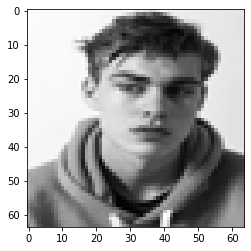

In [12]:
print(row["file"])
plt.imshow(im, cmap='gray')

Convert the lists to ndarrays.

In [13]:
def convert_to_nparray(name, arr):
    np_array = np.asarray(arr)
    print(f"### {name} ###")
    print(type(np_array))
    print(np_array.shape)
    return np_array

In [14]:
awesome_images = convert_to_nparray("images", images)
awesome_hair_length = convert_to_nparray("hair_length", hair_length)
awesome_hair_style = convert_to_nparray("hair_style", hair_style)
awesome_eyes = convert_to_nparray("eyes", eyes)
awesome_eyebrow = convert_to_nparray("eyebrow", eyebrow)
awesome_glasses = convert_to_nparray("glasses", glasses)
awesome_face = convert_to_nparray("face", face)
awesome_skin = convert_to_nparray("skin", skin)
awesome_forehead = convert_to_nparray("forehead", forehead)
awesome_nose = convert_to_nparray("nose", nose)
awesome_beard = convert_to_nparray("beard", beard)
awesome_mouth = convert_to_nparray("mouth", mouth)
awesome_ears = convert_to_nparray("ears", ears)

### images ###
<class 'numpy.ndarray'>
(349, 64, 64, 1)
### hair_length ###
<class 'numpy.ndarray'>
(349,)
### hair_style ###
<class 'numpy.ndarray'>
(349,)
### eyes ###
<class 'numpy.ndarray'>
(349,)
### eyebrow ###
<class 'numpy.ndarray'>
(349,)
### glasses ###
<class 'numpy.ndarray'>
(349,)
### face ###
<class 'numpy.ndarray'>
(349,)
### skin ###
<class 'numpy.ndarray'>
(349,)
### forehead ###
<class 'numpy.ndarray'>
(349,)
### nose ###
<class 'numpy.ndarray'>
(349,)
### beard ###
<class 'numpy.ndarray'>
(349,)
### mouth ###
<class 'numpy.ndarray'>
(349,)
### ears ###
<class 'numpy.ndarray'>
(349,)


In [15]:
awesome_train_dataset = tf.data.Dataset.from_tensor_slices({
    "image": awesome_images,
    "hair_length": awesome_hair_length,
    "hair_style": awesome_hair_style,
    "eyes": awesome_eyes,
    "eyebrow": awesome_eyebrow,
    "glasses": awesome_glasses,
    "face": awesome_face,
    "skin": awesome_skin,
    "forehead": awesome_forehead,
    "nose": awesome_nose,
    "beard": awesome_beard,
    "mouth": awesome_mouth,
    "ears": awesome_ears
}).shuffle(BUFFER_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)

## Create the models


In [16]:
noise_dim = 100

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise) and additional facial characteristics passed as categorical features. Start with a `Dense` layer that takes the seed and the facial characteristics as input, then upsample several times until you reach the desired image size of 64x64x1. Notice the `tf.keras.layers.ReLU` activation for each layer, except the output layer which uses tanh.

![](docs/Text-to-Face_DCGAN_Generator.png)

In [17]:
features = [
    ("hair_length", df["hair_length"].nunique()),
    ("hair_style", df["hair_style"].nunique()),
    ("eyes", df["eyes"].nunique()),
    ("eyebrow", df["eyebrow"].nunique()),
    ("glasses", df["glasses"].nunique()),
    ("face", df["face"].nunique()),
    ("skin", df["skin"].nunique()),
    ("forehead", df["forehead"].nunique()),
    ("nose", df["nose"].nunique()),
    ("beard", df["beard"].nunique()),
    ("mouth", df["mouth"].nunique()),
    ("ears", df["ears"].nunique())
]
print(features)

[('hair_length', 6), ('hair_style', 7), ('eyes', 7), ('eyebrow', 4), ('glasses', 2), ('face', 6), ('skin', 4), ('forehead', 4), ('nose', 5), ('beard', 4), ('mouth', 3), ('ears', 4)]


In [18]:
def build_feature_columns(features: dict):
    feature_layer_inputs = {}
    feature_columns = []
    for name, hash_bucket_size in features:
        feature_columns.append(tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_hash_bucket(name, hash_bucket_size=hash_bucket_size)))
        feature_layer_inputs[name] = layers.Input(shape=(), name=name, dtype=tf.string)
    return feature_columns, feature_layer_inputs

In [19]:
def make_generator_model():
    feature_columns, feature_layer_inputs = build_feature_columns(features=features)
    fc_layer = layers.DenseFeatures(feature_columns)
    fc = fc_layer(feature_layer_inputs)

    image_input = layers.Input(shape=(100,), name='noise')

    x = layers.concatenate([fc, image_input], axis=1)
    x = layers.Dense(4 * 4 * 1024, use_bias=False)(x)
    x = layers.Reshape((4, 4, 1024))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    inputs = list(feature_layer_inputs.values())
    inputs.append(image_input)
    return Model(inputs=inputs, outputs=x, name="generator")

Build the generator model and summarize the structure.

In [20]:
generator = make_generator_model()
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 beard (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 ears (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 eyebrow (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 eyes (InputLayer)              [(None,)]            0           []                               
                                                                                          

Use the (as yet untrained) generator to create an image.

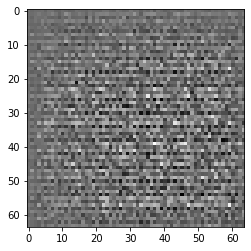

In [21]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator({
    "noise": noise,
    "hair_length": tf.constant(["short"]),
    "hair_style": tf.constant(["straight"]),
    "eyes": tf.constant(["normal"]),
    "eyebrow": tf.constant(["thick"]),
    "glasses": tf.constant(["no"]),
    "face": tf.constant(["distinctive"]),
    "skin": tf.constant(["normal"]),
    "forehead": tf.constant(["normal"]),
    "nose": tf.constant(["normal"]),
    "beard": tf.constant(["no"]),
    "mouth": tf.constant(["normal"]),
    "ears": tf.constant(["normal"])
}, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [22]:
def make_discriminator_model():
    image_input = layers.Input(shape=(pixel, pixel, 1), name='image')

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(image_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)

    feature_columns, feature_layer_inputs = build_feature_columns(features=features)
    fc_layer = layers.DenseFeatures(feature_columns)
    fc = fc_layer(feature_layer_inputs)

    x = layers.concatenate([fc, x], axis=1)

    x = layers.Dense(1)(x)

    inputs = list(feature_layer_inputs.values())
    inputs.append(image_input)
    return Model(inputs=inputs, outputs=x, name="discriminator")

Build the generator model and summarize the structure.

In [23]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1664        ['image[0][0]']                  
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [24]:
decision = discriminator({
    "image": generated_image,
    "hair_length": tf.constant(["short"]),
    "hair_style": tf.constant(["straight"]),
    "eyes": tf.constant(["normal"]),
    "eyebrow": tf.constant(["thick"]),
    "glasses": tf.constant(["no"]),
    "face": tf.constant(["distinctive"]),
    "skin": tf.constant(["normal"]),
    "forehead": tf.constant(["normal"]),
    "nose": tf.constant(["normal"]),
    "beard": tf.constant(["no"]),
    "mouth": tf.constant(["normal"]),
    "ears": tf.constant(["normal"])
})
print(decision)

tf.Tensor([[0.04110563]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [25]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [26]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [27]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [28]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [29]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop
The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [30]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator({
          "noise": noise,
          "hair_length": batch["hair_length"],
          "hair_style": batch["hair_style"],
          "eyes": batch["eyes"],
          "eyebrow": batch["eyebrow"],
          "glasses": batch["glasses"],
          "face": batch["face"],
          "skin": batch["skin"],
          "forehead": batch["forehead"],
          "nose": batch["nose"],
          "beard": batch["beard"],
          "mouth": batch["mouth"],
          "ears": batch["ears"]
      }, training=True)

      real_output = discriminator({
          "image": batch["image"],
          "hair_length": batch["hair_length"],
          "hair_style": batch["hair_style"],
          "eyes": batch["eyes"],
          "eyebrow": batch["eyebrow"],
          "glasses": batch["glasses"],
          "face": batch["face"],
          "skin": batch["skin"],
          "forehead": batch["forehead"],
          "nose": batch["nose"],
          "beard": batch["beard"],
          "mouth": batch["mouth"],
          "ears": batch["ears"]
      }, training=True)
      fake_output = discriminator({
          "image": generated_images,
          "hair_length": batch["hair_length"],
          "hair_style": batch["hair_style"],
          "eyes": batch["eyes"],
          "eyebrow": batch["eyebrow"],
          "glasses": batch["glasses"],
          "face": batch["face"],
          "skin": batch["skin"],
          "forehead": batch["forehead"],
          "nose": batch["nose"],
          "beard": batch["beard"],
          "mouth": batch["mouth"],
          "ears": batch["ears"]
      }, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [31]:
def train(dataset, epochs):
  for epoch in range(1, epochs+1):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    show = True if (epoch % VISUALIZE_EVERY_X_EPOCHS) == 0 else False
    generate_and_save_images(generator, test_noise, "{}/image_at_epoch_{:04d}.png".format(output_dir, epoch), show=show)

    if (epoch % CHECKPOINT_EVERY_X_EPOCHS) == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch, time.time()-start))

**Generate and save images**


In [32]:
num_examples_to_generate = 16
test_noise = tf.random.normal([num_examples_to_generate, noise_dim])
test_hair_length = tf.constant(["short"]*num_examples_to_generate)
test_hair_style = tf.constant(["straight"]*num_examples_to_generate)
test_eyes = tf.constant(["normal"]*num_examples_to_generate)
test_eyebrow = tf.constant(["thick"]*num_examples_to_generate)
test_glasses = tf.constant(["no"]*num_examples_to_generate)
test_face = tf.constant(["distinctive"]*num_examples_to_generate)
test_skin = tf.constant(["normal"]*num_examples_to_generate)
test_forehead = tf.constant(["normal"]*num_examples_to_generate)
test_nose = tf.constant(["normal"]*num_examples_to_generate)
test_beard = tf.constant(["no"]*num_examples_to_generate)
test_mouth = tf.constant(["normal"]*num_examples_to_generate)
test_ears = tf.constant(["normal"]*num_examples_to_generate)

In [33]:
def generate_and_save_images(model, noise, output_path, show, save=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model({
      "noise": noise,
      "hair_length": test_hair_length,
      "hair_style": test_hair_style,
      "eyes": test_eyes,
      "eyebrow": test_eyebrow,
      "glasses": test_glasses,
      "face": test_face,
      "skin": test_skin,
      "forehead": test_forehead,
      "nose": test_nose,
      "beard": test_beard,
      "mouth": test_mouth,
      "ears": test_ears,
  }, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  if save:
    plt.savefig(output_path)
  if show:
    plt.show()

  plt.close(fig)

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

In [34]:
os.makedirs(output_dir, exist_ok=True)

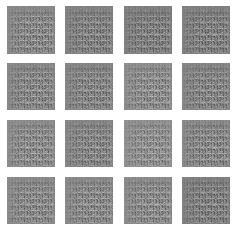

Time for epoch 1 is 7.400146961212158 sec


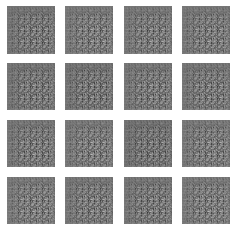

Time for epoch 2 is 1.6794626712799072 sec


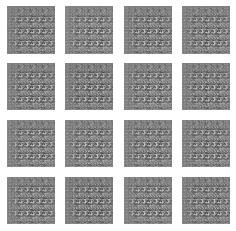

Time for epoch 3 is 2.797107696533203 sec


In [35]:
VISUALIZE_EVERY_X_EPOCHS = 1
CHECKPOINT_EVERY_X_EPOCHS = 3
EPOCHS = 3
train(awesome_train_dataset, EPOCHS)

Restore the latest checkpoint.

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

Use `imageio` to create an animated gif using the images saved during training.

In [37]:
anim_file = f"{output_dir}/dcgan.gif"

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob(f"{output_dir}/image*.png")
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\Tom\AppData\Local\Temp\ipykernel_14208\254506623.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Tom\AppData\Local\Temp\ipykernel_14208\254506623.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



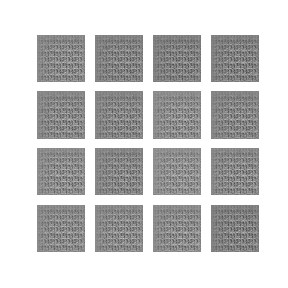

In [38]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Done.